In [1]:
import pandas as pd

reducedPapers = pd.read_csv(
    "../processedData/processedData.csv",
    sep=',',
    index_col=0
)
reducedPapers.dropna(subset = ['processedText'], inplace = True, how='any')
reducedPapers.reset_index(drop=True, inplace=True)
reducedPapers.tail()
reducedPapers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30447 entries, 0 to 30446
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          30447 non-null  int64 
 1   timePeriod     30447 non-null  object
 2   processedText  30447 non-null  object
dtypes: int64(1), object(2)
memory usage: 713.7+ KB


In [2]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

model = BERTopic(
    umap_model=UMAP(n_neighbors=5, n_components=3, min_dist=0.0),
    hdbscan_model=HDBSCAN(min_cluster_size=50, min_samples=5),
    embedding_model=SentenceTransformer('all-MiniLM-L6-v2'),
    vectorizer_model=CountVectorizer(ngram_range=(1, 2), stop_words='english'),
    top_n_words=5,
    language='english',
    calculate_probabilities=True,
    verbose=True,
    min_topic_size=20
)


In [ ]:
import pickle
reducedPapers.loc[:, 'processedText'] = reducedPapers['processedText'].astype("str")
topics, probs = model.fit_transform(reducedPapers['processedText'])
with open('../processedData/topics.pickle', 'wb') as f:
    pickle.dump(topics, f)

Batches:   0%|          | 0/952 [00:00<?, ?it/s]

In [130]:
hierarchical_topics = model.hierarchical_topics(reducedPapers['processedText'])
tree = model.get_topic_tree(hierarchical_topics)
print(tree)

100%|██████████| 60/60 [00:00<00:00, 71.59it/s]

.
├─noble_lord_noble lord_baroness_earl
│    ├─■──baroness_noble baroness_lady_noble_baroness lady ── Topic: 59
│    └─noble_lord_noble lord_earl_lord lord
│         ├─noble_lord_noble lord_amendment_lord lord
│         │    ├─■──amendment_lord_noble_noble lord_amendment noble ── Topic: 58
│         │    └─■──noble_noble lord_lord_viscount_earl ── Topic: 8
│         └─■──lord_lordship_noble_earl_address ── Topic: 53
└─make_government_country_state_great
     ├─committee_amendment_minister_make_matter
     │    ├─committee_amendment_clause_make_matter
     │    │    ├─committee_amendment_clause_vote_propose
     │    │    │    ├─■──reading_second reading_second_respect_vote second ── Topic: 48
     │    │    │    └─committee_amendment_clause_vote_principle
     │    │    │         ├─committee_amendment_clause_vote_report
     │    │    │         │    ├─■──amendment_clause_amendment amendment_accept amendment_accept ── Topic: 14
     │    │    │         │    └─committee_clause_vote_repor

In [131]:
fig = model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, title='<b>Hierarchical Clustering</b>')
fig.write_image("../diagramOutput/hierarchicalClustering.png", engine="kaleido", scale=3, format='png')
fig.show()

In [132]:
model.visualize_heatmap()

In [133]:
import pickle
with open('../processedData/topics.pickle', 'wb') as f:
    pickle.dump(topics, f)

In [134]:
fig = model.visualize_barchart(top_n_topics=38, n_words=5, title='<b>Top Word Scores</b>')
fig.write_image("../diagramOutput/hierarchicalClustering.png", engine="kaleido", scale=3, format='png')
fig.show()

In [135]:
topics_over_time = model.topics_over_time(reducedPapers['processedText'],
                                                reducedPapers['timePeriod'],
                                                global_tuning=True,
                                              evolution_tuning=True,
                                                nr_bins=20)

with open('../processedData/topics_over_time.pickle', 'wb') as f:
    pickle.dump(topics_over_time, f)

16it [00:33,  2.10s/it]


In [136]:
#model.visualize_topics_over_time(topics_over_time, top_n_topics=5)
model.visualize_topics_over_time(topics_over_time)

fig = model.visualize_topics_over_time(topics_over_time, title='<b>Topics over Time</b>')
fig.write_image("../diagramOutput/topicsOverTime.png", engine="kaleido", scale=3, format='png')
fig.show()


In [137]:
fig = model.visualize_topics(title='<b>Intertopic Distance Map</b>')
fig.write_image("../diagramOutput/intertopicDistanceMap.png", engine="kaleido", scale=3, format='png')
fig.show()

In [141]:
similarWords = (
    "king "
    "prince "
    "princess "
    "queen "
    "royal "
    "royalty "
    "majesty "
)

In [142]:
similar_topics, similarity = model.find_topics(similarWords)
print(similar_topics)

[56, 59, 44, 8, 52]


In [143]:
model.get_topic(similar_topics[0])

[('pergami', 0.09999927351030781),
 ('royal highness', 0.08676628440174704),
 ('highness', 0.0859735456510546),
 ('royal', 0.06832863027175934),
 ('room', 0.06666678687530077)]

In [144]:
#model.visualize_topics_over_time(topics_over_time, top_n_topics=5)
#model.visualize_topics_over_time(topics_over_time)

fig = model.visualize_topics_over_time(topics_over_time, title='<b>Topics over Time</b>', topics=similar_topics)
fig.write_image("../diagramOutput/topicsOverTimeReduced.png", engine="kaleido", scale=3, format='png')
fig.show()

In [145]:
import pandas as pd
from umap import UMAP
%matplotlib inline

embeddings_vis = model._extract_embeddings(reducedPapers['processedText'], method="document")
umap_model_vis = UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='cosine').fit(embeddings_vis)
df_vis = pd.DataFrame(umap_model_vis.embedding_, columns=["x", "y"])
df_vis["topic"] = topics

KeyboardInterrupt: 

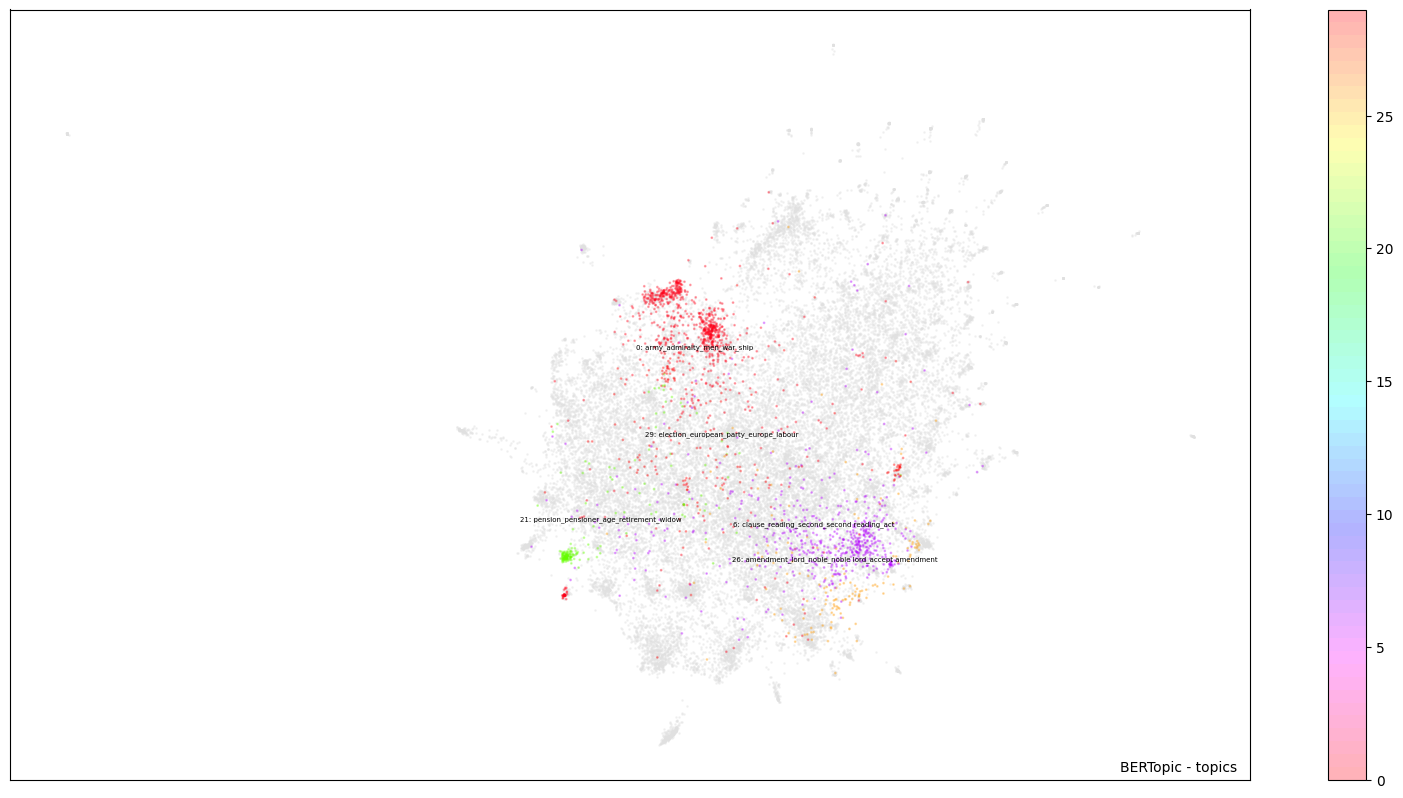

In [127]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot parameters
topicsNotToDisplay = [i for i in range(0, len(np.unique(topics))) if i not in similar_topics]
fontsize = 5 #12

to_plot = df_vis.copy()
#to_plot[df_vis.topic >= top_n] = -1
for tp in topicsNotToDisplay:
    to_plot.loc[to_plot.topic == tp, 'topic'] = -1

outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]

n_topics = len(np.unique(topics))
cmap = plt.get_cmap('hsv_r', n_topics)

fig, ax = plt.subplots(figsize=(20, 10), facecolor='white')
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)

centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
   topic = int(row[1].topic)
   text = f"{topic}: " + "_".join([x[0] for x in model.get_topic(topic)[:5]])
   ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')

ax.text(0.99, 0.01, f"BERTopic - topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(scatter)

plt.savefig("../diagramOutput/clusterSelected.png", dpi=900, bbox_inches='tight')
plt.show()

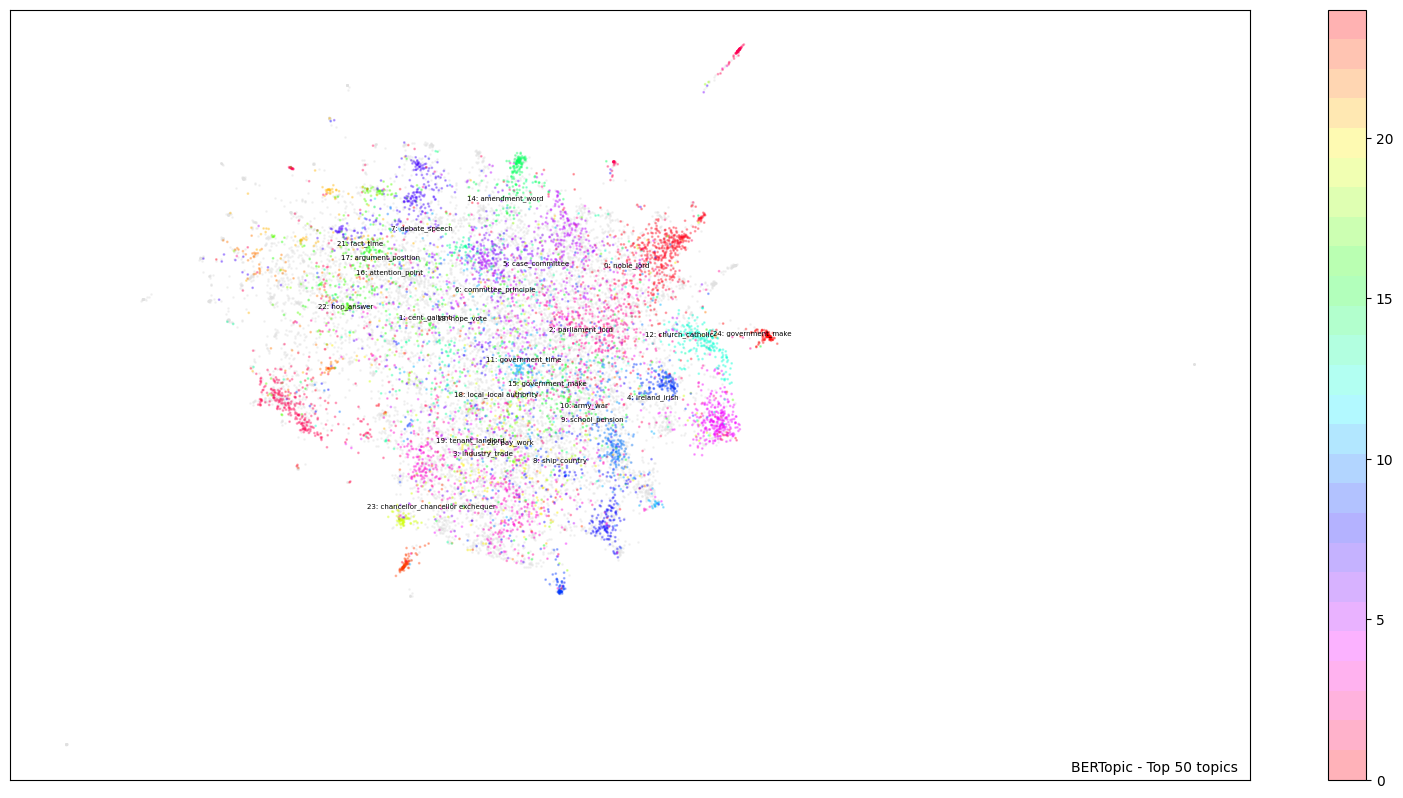

In [91]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot parameters
top_n = 50
fontsize = 5 #12

to_plot = df_vis.copy()
to_plot[df_vis.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]

n_topics = len(np.unique(topics))
cmap = plt.get_cmap('hsv_r', n_topics)

fig, ax = plt.subplots(figsize=(20, 10), facecolor='white')
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)

centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
   topic = int(row[1].topic)
   text = f"{topic}: " + "_".join([x[0] for x in model.get_topic(topic)[:2]])
   ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')

ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(scatter)

plt.savefig("../diagramOutput/cluster.png", dpi=900, bbox_inches='tight')
plt.show()